Split the data into training, test, and validation folders

In [ ]:
!pip install patchify
!pip install segmentation-models-pytorch
!pip install torchmetrics
!pip install torch_snippets pytorch_model_summary
from IPython.display import clear_output
clear_output()

In [ ]:
# %% Purpose:
# 1. Prepare images and masks folder within train, val, test folder
# 2. copy all images into these folders
# 3. create patches of images
#%% Packages
import os
import re
from pathlib import Path
import numpy as np
import math
from patchify import patchify
from PIL import Image
import shutil

from torch.utils.data import Dataset
import cv2

import numpy as np
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import seaborn as sns
import matplotlib.pyplot as plt


from torch_snippets import *

import torchmetrics

#%% Constants
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
print(DEVICE)

cuda


**UTILITY FUNCTIONS**

In [ ]:

def delete_split_folders(dest):
    FOLDERS = ['train', 'val', 'test']
    for folder in FOLDERS:
        dest_folder = os.path.join(dest, folder)
        #print(dest_folder)
        if os.path.exists(dest_folder):
          #delete folder if exists
          shutil.rmtree(dest_folder)


def create_split_folders(dest):
    FOLDERS = ['train', 'val', 'test']
    for folder in FOLDERS:
        dest_folder = os.path.join(dest, folder)
        if not os.path.exists(dest_folder):
            folder_imgs = f"{dest_folder}/images"
            folder_msks = f"{dest_folder}/masks"
            os.makedirs(folder_imgs) if not os.path.exists(folder_imgs) else print('folder already exists')
            os.makedirs(folder_msks) if not os.path.exists(folder_msks) else print('folder already exists')

    models_folder = os.path.join(dest, "models")
    if not os.path.exists(models_folder):
        os.makedirs(models_folder) if not os.path.exists(models_folder) else print('folder already exists')


def split_train_test_val_folders(data_dir, train_ratio, val_ratio):
  #get list of filenames in the data directory
  file_list = os.listdir(data_dir)
  np.random.shuffle(file_list)


  train_size = int(len(file_list) * train_ratio)
  val_size = int(len(file_list) * val_ratio)

  train_files = file_list[:train_size]
  train_list = [x[6:10] for x in train_files]
  val_files   = file_list[train_size:train_size + val_size]
  val_list = [x[6:10] for x in val_files]
  test_files  = file_list[train_size + val_size:]
  test_list = [x[6:10] for x in test_files]
  return train_list, val_list, test_list


CREATE PATCHES

In [ ]:
def create_patches(src, dest_path):
    path_split = os.path.split(src)
    image = Image.open(src)
    image = np.asarray(image)
    if len(image.shape) > 2:  # only if color channel exists as well
        patches = patchify(image, (224, 224, 3), step=300)
        file_name_wo_ext = Path(src).stem
        for i in range(patches.shape[0]):
            for j in range(patches.shape[1]):
                patch = patches[i, j, 0]
                patch = Image.fromarray(patch)
                num = i * patches.shape[1] + j
                patch.save(f"{dest_path}/{file_name_wo_ext}_patch_{num}.png")


def preprocess_data(src_dir, dest_dir, train_list, val_list, test_list):
    for path_name, _, file_name in os.walk(src_dir):
      for f in file_name:
        path_split = os.path.split(path_name)
        img_type = path_split[1]  # either 'clean which are masks' or 'render which are images'

        #get the file number
        if img_type == 'render' or img_type == 'ground':
          file_num = f[6:10]
        elif img_type == 'clean':
          file_num = f[5:9]
        else:
          print(f"unknown type {img_type}")
          return

        if file_num in val_list:
            target_folder = os.path.join(dest_dir, 'val')
        elif file_num in test_list:
            target_folder = os.path.join(dest_dir, 'test')
        elif file_num in train_list:
            target_folder = os.path.join(dest_dir, 'train')
        else:
          print(f"unknown list for {file_num}")
          return

        # copy all images
        src = os.path.join(path_name, f)

        # create patches
        if img_type == 'render':
            dest = os.path.join(target_folder, "images")
            create_patches(src=src, dest_path=dest)

        # copy all masks
        if img_type == 'clean':
            dest = os.path.join(target_folder, "masks")
            create_patches(src=src, dest_path=dest)

**PREPROCESSING**

In [ ]:
data_dir = Path('drive/MyDrive/MoonImages/')
working_dir = Path('drive/MyDrive/MoonWorking/')
render_dir = data_dir/"render/"


#delete_split_folders(working_dir)
#create_split_folders(working_dir)
train_list, val_list, test_list = split_train_test_val_folders(render_dir, train_ratio=0.7, val_ratio=0.15)
preprocess_data(data_dir, working_dir, train_list, val_list, test_list)


In [ ]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])



**DATASET**

In [ ]:

class SegmentationDataset(Dataset):
    """Create Semantic Segmentation Dataset. Read images, apply augmentations, and process transformations

    Args:
        Dataset (image): Lunar Dataset
    """
    # CLASSES = {'ground': 0, 'sky': 76, 'bigrocks':29, 'smallrocks':149}


    def __init__(self, path_name) -> None:
        super().__init__()
        self.path_name = path_name
        self.get_images_masks(path_name)

    def get_images_masks(self, path_name):
        image_names = os.listdir(f"{path_name}/images")
        masks_names = os.listdir(f"{path_name}/masks")

        # filter all images that do not exist in both folders
        img_stem = [i.replace('render', '')for i in image_names]
        msk_stem = [i.replace('clean', '')  for i in masks_names]
        self.img_msk_stem = set(img_stem) & set(msk_stem)
        self.image_paths = [f"{path_name}/images/render{i}" for i in self.img_msk_stem]
        self.masks_paths = [f"{path_name}/masks/clean{i}" for i in self.img_msk_stem]

    def encode_mask(self, mask):
        #mask[mask == 0] = 0  # black ground
        mask[mask == 76] = 1   # red sky
        mask[mask == 29] = 2  # blue big rocks
        mask[mask == 149] = 3  # green small rocks
        return mask

    def decode_mask(self, mask):
        mask[mask == 1] = 76   # red sky
        mask[mask == 2] = 29  # blue big rocks
        mask[mask == 3] = 149  # green small rocks
        return mask

    def __len__(self):
        return len(self.img_msk_stem)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        mask_path = self.masks_paths[index]

        image = cv2.imread(image_path)
        if image is None:  # Check if image loading failed
          print(f"Failed to load image: {image_path}")
          return None  # Handle the error appropriately

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.transpose((2, 0, 1))  #structure: BS, C, H, W

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:  # Check if mask loading failed
            print(f"Failed to load mask: {mask_path}")
            return None  # Handle the error appropriately

        mask = self.encode_mask(mask)
        return image, mask

    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks



In [ ]:
ce = nn.CrossEntropyLoss()
def ResnextLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

**MODEL SETUP**

In [ ]:

# Hyperparameters

BS = 4

train_path_name = os.path.join(working_dir, 'train')
val_path_name = os.path.join(working_dir, 'val')
# Instantiate Dataset and Dataloader
train_ds = SegmentationDataset(path_name=train_path_name)
train_dataloader = DataLoader(train_ds, batch_size=BS, shuffle=True)
val_ds = SegmentationDataset(path_name=val_path_name)
val_dataloader = DataLoader(val_ds, batch_size=BS, shuffle=True)

model = smp.FPN(encoder_name='resnext50_32x4d', encoder_weights='imagenet',
                classes=4,activation='sigmoid').to(DEVICE)
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001),])
criterion = ResnextLoss
#train_losses, val_losses = [], []



**UNTESTED TRAINING LOOP**

In [ ]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    ims=ims.to(DEVICE).float()
    ce_masks=ce_masks.to(DEVICE).long()
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    ims=ims.to(DEVICE).float()
    masks=masks.to(DEVICE).long()
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
n_epochs = 20

log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(train_dataloader)
    for bx, data in enumerate(train_dataloader):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dataloader)
    for bx, data in enumerate(val_dataloader):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')

    log.report_avgs(ex+1)

EPOCH: 1.000  trn_loss: 0.784  val_acc: 0.961  val_loss: 0.783  trn_acc: 0.960  (490.50s - 9319.42s remaining)
EPOCH: 2.000  trn_loss: 0.784  val_acc: 0.960  val_loss: 0.783  trn_acc: 0.960  (978.30s - 8804.68s remaining)
EPOCH: 3.000  trn_loss: 0.783  val_acc: 0.960  val_loss: 0.783  trn_acc: 0.960  (1467.77s - 8317.34s remaining)
EPOCH: 4.000  trn_loss: 0.783  val_acc: 0.960  val_loss: 0.783  trn_acc: 0.960  (1957.95s - 7831.81s remaining)
EPOCH: 5.000  trn_loss: 0.783  val_acc: 0.960  val_loss: 0.784  trn_acc: 0.961  (2447.15s - 7341.46s remaining)
EPOCH: 6.000  trn_loss: 0.783  val_acc: 0.959  val_loss: 0.784  trn_acc: 0.961  (2941.31s - 6863.05s remaining)
EPOCH: 7.000  trn_loss: 0.783  val_acc: 0.961  val_loss: 0.783  trn_acc: 0.961  (3429.71s - 6369.47s remaining)
EPOCH: 8.000  trn_loss: 0.783  val_acc: 0.961  val_loss: 0.783  trn_acc: 0.961  (3919.43s - 5879.15s remaining)
EPOCH: 9.000  trn_loss: 0.783  val_acc: 0.961  val_loss: 0.782  trn_acc: 0.961  (4410.38s - 5390.47s remai

In [ ]:
torch.save(model.state_dict(), f'models/FPN_epochs_{n_epochs}_crossentropy_state_dict.pth')

100%|██████████| 121/121 [00:04<00:00, 26.06it/s]


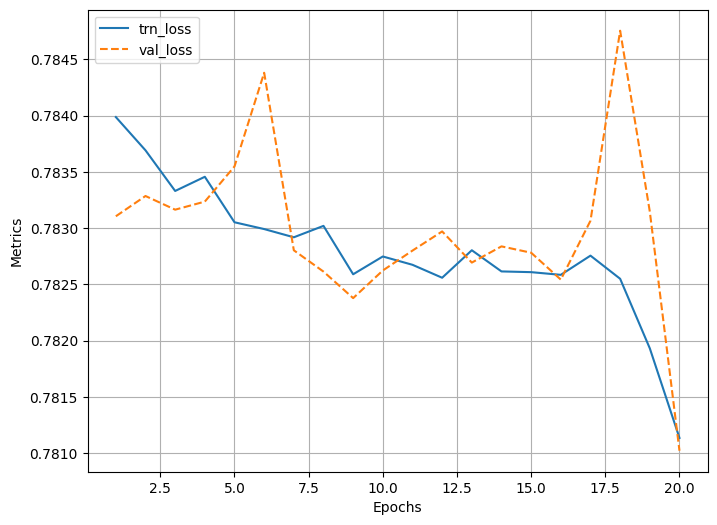

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])

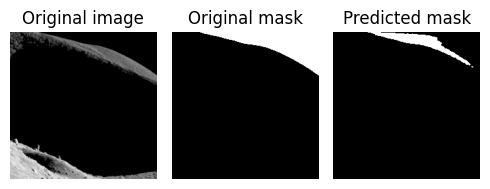

In [ ]:
im, mask = next(iter(val_dataloader))
im = im.to(DEVICE).float()
mask = mask.to(DEVICE)
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)
subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0]
,_mask.permute(1,2,0).detach().cpu()[:,:,0]],
nc=3, titles=['Original image','Original mask','Predicted mask'])

**Test LOOP**

In [ ]:


test_path_name = os.path.join(working_dir, 'test')
#%% Dataset and Dataloader
test_ds = SegmentationDataset(path_name=test_path_name)
test_dataloader = DataLoader(test_ds, batch_size=1, shuffle=True)

#Model setup
model = smp.FPN(
    encoder_name="resnext50_32x4d",
    encoder_weights='imagenet',
    classes=4,
    activation='sigmoid',
)
model.to(DEVICE)

#%% load weights
model.load_state_dict(torch.load(f'models/FPN_epochs_{n_epochs}_crossentropy_state_dict.pth'))

#%% Model Evaluation
pixel_accuracies = []
intersection_over_unions = []
metric_iou = torchmetrics.JaccardIndex(num_classes=4, task='multiclass').to(DEVICE)

with torch.no_grad():
    for data in test_dataloader:
        inputs, outputs = data
        true = outputs.to(torch.float32)
        pred = model(inputs.to(DEVICE).float())
        _, predicted = torch.max(pred, 1)
        true = true.to(DEVICE)
        correct_pixels = (true == predicted).sum().item()
        total_pixels = true.size(1) * true.size(2)
        pixel_accuracies.append(correct_pixels / total_pixels)
        iou = metric_iou(predicted.float(), true).item()
        intersection_over_unions.append(iou)

# Median Accuracy
print(f"Median Pixel Accuracy: {np.median(pixel_accuracies) * 100 }")
print(f"Median IoU: {np.median(intersection_over_unions) * 100 }")

# Pick a test image and show it
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))

#\ EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape
#%% trick to cover all classes
# use at least one pixel for each class for both images
required_range = list(range(4))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3


mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3

#%%
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()
# %%


In [ ]:
@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    ims=ims.to(DEVICE).float()
    masks=masks.to(DEVICE).long()
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [ ]:
# Pick a test image and show it
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))

#\ EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape
#%% trick to cover all classes
# use at least one pixel for each class for both images
required_range = list(range(4))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3


mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3

#%%
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()
# %%


In [ ]:
# Pick a test image and show it
image_test, mask = next(iter(test_dataloader))
plt.imshow(np.transpose(image_test[0, :, :, :].cpu().numpy(), (1, 2, 0)))

#\ EVALUATE MODEL
# create preds
with torch.no_grad():
    image_test = image_test.float().to(DEVICE)
    output = model(image_test)

#%%
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape
#%% trick to cover all classes
# use at least one pixel for each class for both images
required_range = list(range(4))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3


mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3

#%%
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()
# %%


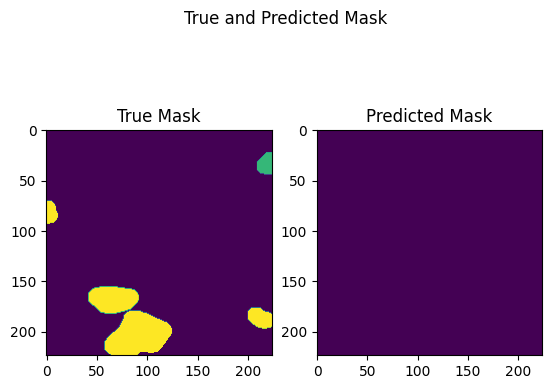

In [ ]:
output_cpu = output.cpu().squeeze().numpy()
output_cpu = output_cpu.transpose((1, 2, 0))
output_cpu = output_cpu.argmax(axis=2)
output_cpu.shape
#%% trick to cover all classes
# use at least one pixel for each class for both images
required_range = list(range(4))
output_cpu[0, 0] = 0
output_cpu[0, 1] = 1
output_cpu[0, 2] = 2
output_cpu[0, 3] = 3


mask[0, 0, 0] = 0
mask[0, 0, 1] = 1
mask[0, 0, 2] = 2
mask[0, 0, 3] = 3

#%%
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.suptitle('True and Predicted Mask')
axs[0].imshow(mask[0, :, :])
axs[1].imshow(output_cpu)
axs[0].set_title("True Mask")
axs[1].set_title("Predicted Mask")
plt.show()